- PassengerId 整型变量，标识乘客的ID，递增变量，对预测无帮助
- Survived 整型变量，标识该乘客是否幸存。0表示遇难，1表示幸存。将其转换为factor变量比较方便处理
- Pclass 整型变量，标识乘客的社会-经济状态，1代表Upper，2代表Middle，3代表Lower
- Name 字符型变量，除包含姓和名以外，还包含Mr.
- Mrs. Dr.这样的具有西方文化特点的信息
- Sex 字符型变量，标识乘客性别，适合转换为factor类型变量
- Age 整型变量，标识乘客年龄，有缺失值
- SibSp 整型变量，代表兄弟姐妹及配偶的个数。其中Sib代表Sibling也即兄弟姐妹，Sp代表Spouse也即配偶
- Parch 整型变量，代表父母或子女的个数。其中Par代表Parent也即父母，Ch代表Child也即子女
- Ticket 字符型变量，代表乘客的船票号 Fare 数值型，代表乘客的船票价
- Cabin 字符型，代表乘客所在的舱位，有缺失值
- Embarked 字符型，代表乘客登船口岸，适合转换为factor型变量

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import xgboost as XGB

In [ ]:
train = pd.read_csv("train.csv")
train.head(5)
test=pd.read_csv("test.csv")

In [54]:
# 1. 数据预处理——Embarked和Sex
train['Embarked'].unique()
def handle_category(data:pd.DataFrame):
    data['Embarked'].fillna('S',inplace=True)
    data['Embarked']=data['Embarked'].astype('category')
    data['Embarked']=data['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
    data['Sex']=data['Sex'].astype('category')
    data['Sex']=data['Sex'].map({'male':0,'female':1}).astype(int)
    return data
train=handle_category(train)
test=handle_category(test)

In [55]:
# 2.0 数据预处理——分割姓名称谓并统计数据
from preparation import words_statistic
#展示name中单词的统计频次
words=words_statistic(train['Name'],'[A-Za-z]+\.?')
words


,key,count
0,Mr.,517
1,Miss.,182
2,Mrs.,125
3,William,63
4,John,44
...,...,...
1528,del,1
1529,der,1
1530,hoef,1
1531,of,1


In [56]:
from preparation import get_title
# 2.1 从名字中提取高频单词作为新特征
# 我们认为数量太少的体现不出规律，所以至少要达到1%的占比
title_list=words['key'].loc[words['count']>train.shape[0]*0.01]
train_titles=get_title(train['Name'],title_list)
test_titles=get_title(test['Name'],title_list)

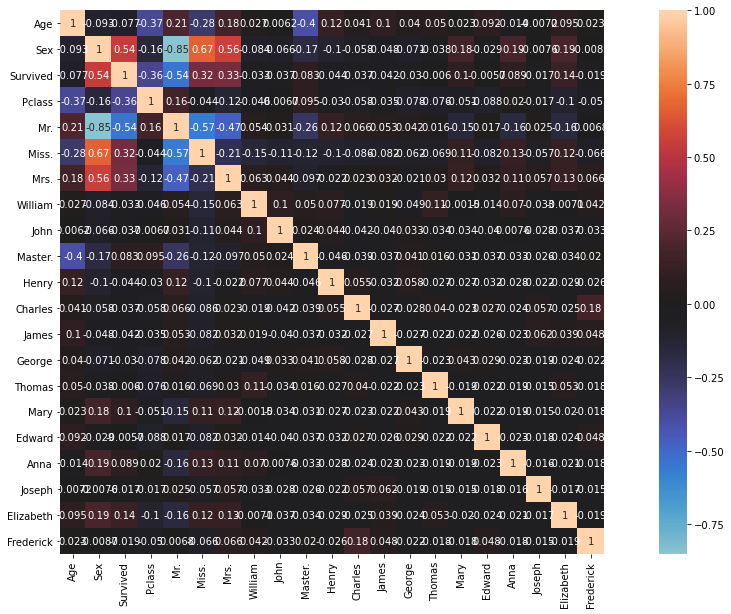

In [57]:
# 2.2 展示称谓特征及与性别和年龄的相关性
isnaAge=train['Age'].isna()
mix_train=pd.concat(
    [   train[['Age','Sex','Survived','Pclass']] , train_titles[words['key'].loc[:16]] ]
                       ,axis=1).loc[~isnaAge]
plt.figure(figsize=(20,10))
sns.heatmap(mix_train.corr(),square=True,annot=True,center = 0)

In [58]:
# 2.3 提炼出称谓特征 train_title 和 test_title
print(mix_train[["Sex", 'Mr.','Mrs.','Miss.','Master.']].groupby("Sex").mean())
# 发现 'Mr.'和'Master.'总是男性；'Mrs.','Miss.'总是女性。
# 这4个属性与性别高度冗余，可以设一个 title 属性，将 'Master.'和 'Miss.'映射为1，将'Mr.'和'Mrs.'映射为2，通过性别就可以完全区分开来。
# 其余称谓或无称谓一律映射为0。
def to_title(title_matrix:pd.DataFrame):
    change_coefficient={'Mr.':2,'Mrs.':2,'Miss.':1,'Master.':1}
    ret = np.zeros(shape=(title_matrix.shape[0],),dtype=np.int)
    for key,c in change_coefficient.items():
        ret+= title_matrix[key].to_numpy(dtype=np.int)*c
    return pd.Series(ret,name='Title')
train_title=to_title(train_titles)  # 注意 train_title 是 pandas.Series 不再是矩阵
test_title=to_title(test_titles)

          Mr.      Mrs.     Miss.  Master.
Sex                                       
0    0.878587  0.000000  0.000000  0.07947
1    0.000000  0.413793  0.559387  0.00000


In [59]:
# 2.4 其余姓名特征降维处理
# 由于其他特征过于稀疏，需要降维压缩减少过拟合
names_feather=pd.concat([train_titles,test_titles],axis=0).drop(['Mr.','Mrs.','Miss.','Master.'],axis=1)
pca=PCA(n_components=0.6)   # 这些特征随机因素太大，所以保留的维度不能太多，否则容易过拟合
train_namesF=pca.fit_transform(train_titles.drop(['Mr.','Mrs.','Miss.','Master.'],axis=1),y=train[["Survived","Age"] ])
test_namesF=pca.transform(test_titles.drop(['Mr.','Mrs.','Miss.','Master.'],axis=1))


In [60]:
# 3.0 分析 Ticket 特征
import re #正则表达式
ticket_pattern=re.compile('([A-Za-z]+\.?)+/?[0-9]?')
ticket_words=words_statistic(train['Ticket'],ticket_pattern)
#展示 Ticket 中关键词的统计频次
print(ticket_words.loc[:30])

      key  count
0      PC     60
1      A.     33
2       A     25
3      C.     23
4       O     20
5   SOTON     18
6    STON     18
7      SC     13
8      W.     10
9     CA.      8
10     Q.      8
11      C      7
12     OQ      7
13  PARIS      7
14     PP      7
15     CA      6
16     P.      6
17   LINE      4
18      P      4
19  Paris      4
20     AH      3
21     O.      3
22      W      2
23     WE      2
24  Basle      1
25     Fa      1
26      S      1
27    SCO      1
28     SO      1
29     SW      1


In [61]:
ticket_keys=ticket_words['key'].loc[ticket_words['count']>1]
train_ticket=get_title(train['Ticket'],ticket_keys)
test_ticket=get_title(test['Ticket'],ticket_keys)

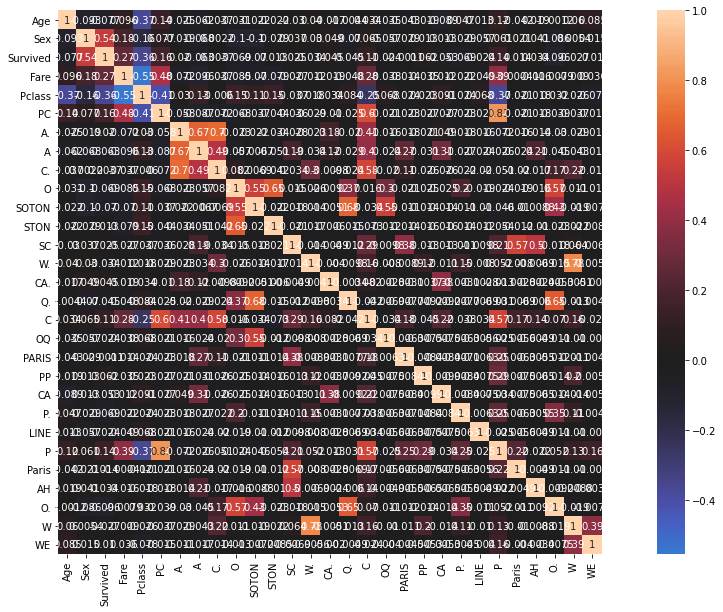

In [64]:
# 3.2 展示票与性别、年龄、生存和费用的相关性
isnaAge=train['Age'].isna()
mix_train=pd.concat(
    [   train[['Age','Sex','Survived','Fare','Pclass']] , train_ticket ]
                       ,axis=1).loc[~isnaAge]
plt.figure(figsize=(20,10))
sns.heatmap(mix_train.corr(),square=True,annot=True,center = 0)

In [68]:
# 3.3 发现有多重共线性，还有与Fare有关，同样用PCA进行降维，解决多重共线性，降低冗余度
pca=PCA(n_components=0.6)
train_ticketF=pca.fit_transform(train_ticket,y=train['Survived'])
test_ticketF=pca.transform(test_ticket)

In [93]:
# train.describe()
# 训练年龄预测模型
naAge_train=train['Age'].isna()
naAge_test=test['Age'].isna()
# 注意预测age不能使用Survived属性
ori_lable_for_age=['Pclass','Sex','SibSp','Parch','Embarked']
AgeTrainX=pd.concat([train[ori_lable_for_age] ,     # 原始数据集去掉无意义和不可以使用的特征
                     train_title ,   # 称谓特征，与年龄高度相关
                     # pd.DataFrame(np.concatenate( (train_namesF      # 姓名关键词的PCA降维特征
                     #                              ,train_ticketF),axis=1  ) ) # 票号关键词的PCA降维特征，说不定某些票需要特定年龄购买
                     ],axis=1).loc[~naAge_train]
sqrtAgeTrainY=np.sqrt(train['Age'].loc[~naAge_train].to_numpy ())   # 对年龄进行开方以提高低龄段的敏感度
# test数据集不能训练 Age预测器，只是用来检验 Age预测器的效果及其泛用性。
AgeTestX=pd.concat([test[ori_lable_for_age] ,test_title
                       # ,pd.DataFrame( np.concatenate((test_namesF,test_ticketF) ,axis=1) )
                    ],axis=1).loc[~naAge_test]
AgeTestY=test['Age'].loc[~naAge_test]


In [98]:
params={
    'n_estimators':200,
    'objective':'square',
    'max_depth':5,
    'learning_rate':0.1,
}
xgb=XGB.XGBClassifier(**params)
xgb.fit(AgeTrainX,sqrtAgeTrainY)
AgeTestAnsY=xgb.predict(AgeTestX)**2

C:\Users\java_lee\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


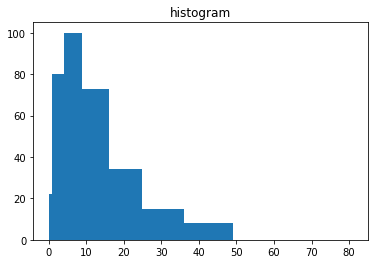

In [108]:
from sklearn.metrics import mean_squared_error # 均方误差
mean_squared_error(AgeTestY,AgeTestAnsY)
std_error_list=np.fabs(AgeTestY-AgeTestAnsY)
hist,AgeBins = np.histogram(std_error_list,bins = np.square(list(range(10))) )
plt.hist(std_error_list, bins =  AgeBins)
plt.title("histogram")
plt.show()
